In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
DIR = '/content/gdrive/My Drive/Spark/data/'

In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
#!pip install pyspark

     |████████████████████████████████| 215.7MB 67kB/s 
     |████████████████████████████████| 204kB 44.3MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130387 sha256=482f1693251ad4a3df2537b27991b78137011c928fe42cef1cc403329bf6e70d
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


In [5]:
ls

gdrive/       spark-2.4.4-bin-hadoop2.7/
sample_data/  spark-2.4.4-bin-hadoop2.7.tgz


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7")# SPARK_HOME

In [0]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession \
        .builder \
        .appName('Python Spark K-means example') \
        .config('spark.some.config.option', 'some-value') \
        .getOrCreate()

## K-means

In [9]:
file_loc = DIR + 'iris.csv'
#print(file_loc)
df = spark.read.csv(file_loc, inferSchema=True, header=True)
print(type(df))

<class 'pyspark.sql.dataframe.DataFrame'>


In [10]:
df.show(5)

+---+---+---+---+------+
|5.1|3.5|1.4|0.2|setosa|
+---+---+---+---+------+
|4.9|3.0|1.4|0.2|setosa|
|4.7|3.2|1.3|0.2|setosa|
|4.6|3.1|1.5|0.2|setosa|
|5.0|3.6|1.4|0.2|setosa|
|5.4|3.9|1.7|0.4|setosa|
+---+---+---+---+------+
only showing top 5 rows



In [11]:
from pyspark.sql.functions import isnan, when, count, col

df.count()

149

In [12]:
df.printSchema()

root
 |-- 5.1: double (nullable = true)
 |-- 3.5: double (nullable = true)
 |-- 1.4: double (nullable = true)
 |-- 0.2: double (nullable = true)
 |-- setosa: string (nullable = true)



In [14]:
df.describe().show()

+-------+------------------+------------------+------------------+------------------+---------+
|summary|               5.1|               3.5|               1.4|               0.2|   setosa|
+-------+------------------+------------------+------------------+------------------+---------+
|  count|               149|               149|               149|               149|      149|
|   mean| 5.848322147651008| 3.051006711409397|3.7744966442953043|1.2053691275167793|     null|
| stddev|0.8285940572656166|0.4334988777167475|1.7596511617753412|0.7612920413899604|     null|
|    min|               4.3|               2.0|               1.0|               0.1|   setosa|
|    max|               7.9|               4.4|               6.9|               2.5|virginica|
+-------+------------------+------------------+------------------+------------------+---------+



In [0]:
# convert data to dense vector
from pyspark.ml.linalg import Vectors

def transData(data):
  return data.rdd.map(lambda r: [Vectors.dense(r[:-1])]).toDF(['features'])

In [20]:
transformed = transData(df)
transformed.show(5)

+-----------------+
|         features|
+-----------------+
|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|
|[5.4,3.9,1.7,0.4]|
+-----------------+
only showing top 5 rows



In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

featureIndexer = VectorIndexer(inputCol = 'features', \
                               outputCol = 'indexedFeatures', \
                               maxCategories = 4).fit(transformed)

data = featureIndexer.transform(transformed)

In [23]:
data.show(5, False)

+-----------------+-----------------+
|features         |indexedFeatures  |
+-----------------+-----------------+
|[4.9,3.0,1.4,0.2]|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|[5.0,3.6,1.4,0.2]|
|[5.4,3.9,1.7,0.4]|[5.4,3.9,1.7,0.4]|
+-----------------+-----------------+
only showing top 5 rows



In [27]:
import numpy as np
from pyspark.ml.clustering import KMeans

cost = np.zeros(20)
for k in range(2,20):
  kmeans = KMeans()\
           .setK(k)\
           .setSeed(1)\
           .setFeaturesCol('indexedFeatures')\
           .setPredictionCol('cluster')

  model = kmeans.fit(data)
  cost[k] = model.computeCost(data)
  print(k)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


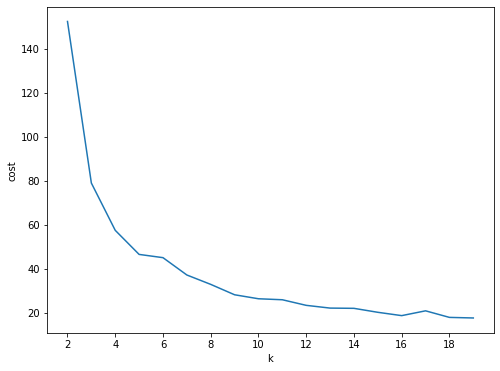

In [28]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(range(2,20), cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [0]:
# choose k = 3

kmeans = KMeans()\
         .setK(3)\
         .setFeaturesCol('indexedFeatures')\
         .setPredictionCol('cluster')

pipeline = Pipeline(stages = [featureIndexer,kmeans])
model = pipeline.fit(transformed)
cluster = model.transform(transformed)

In [0]:
cluster = model.transform(transformed)

In [32]:
cluster.show()

+-----------------+-----------------+-------+
|         features|  indexedFeatures|cluster|
+-----------------+-----------------+-------+
|[4.9,3.0,1.4,0.2]|[4.9,3.0,1.4,0.2]|      1|
|[4.7,3.2,1.3,0.2]|[4.7,3.2,1.3,0.2]|      1|
|[4.6,3.1,1.5,0.2]|[4.6,3.1,1.5,0.2]|      1|
|[5.0,3.6,1.4,0.2]|[5.0,3.6,1.4,0.2]|      1|
|[5.4,3.9,1.7,0.4]|[5.4,3.9,1.7,0.4]|      1|
|[4.6,3.4,1.4,0.3]|[4.6,3.4,1.4,0.3]|      1|
|[5.0,3.4,1.5,0.2]|[5.0,3.4,1.5,0.2]|      1|
|[4.4,2.9,1.4,0.2]|[4.4,2.9,1.4,0.2]|      1|
|[4.9,3.1,1.5,0.1]|[4.9,3.1,1.5,0.1]|      1|
|[5.4,3.7,1.5,0.2]|[5.4,3.7,1.5,0.2]|      1|
|[4.8,3.4,1.6,0.2]|[4.8,3.4,1.6,0.2]|      1|
|[4.8,3.0,1.4,0.1]|[4.8,3.0,1.4,0.1]|      1|
|[4.3,3.0,1.1,0.1]|[4.3,3.0,1.1,0.1]|      1|
|[5.8,4.0,1.2,0.2]|[5.8,4.0,1.2,0.2]|      1|
|[5.7,4.4,1.5,0.4]|[5.7,4.4,1.5,0.4]|      1|
|[5.4,3.9,1.3,0.4]|[5.4,3.9,1.3,0.4]|      1|
|[5.1,3.5,1.4,0.3]|[5.1,3.5,1.4,0.3]|      1|
|[5.7,3.8,1.7,0.3]|[5.7,3.8,1.7,0.3]|      1|
|[5.1,3.8,1.5,0.3]|[5.1,3.8,1.5,0.